In [49]:
!pip3 install pandas numpy seaborn kaggle matplotlib scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

# Obtener los datos

In [51]:
from pathlib import Path
import shutil

# Cargar el archivo kaggle.json para autenticación con la API de Kaggle

# Suponiendo que kaggle.json está en el directorio actual
kaggle_json = Path('kaggle.json')
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)
shutil.copy(str(kaggle_json), str(kaggle_dir / 'kaggle.json'))

# Establecer permisos adecuados
os.chmod(str(kaggle_dir / 'kaggle.json'), 0o600)

In [52]:
!kaggle datasets download -d neuromusic/avocado-prices -p ./ --unzip

Dataset URL: https://www.kaggle.com/datasets/neuromusic/avocado-prices
License(s): ODbL-1.0




  0%|          | 0.00/629k [00:00<?, ?B/s]
100%|██████████| 629k/629k [00:00<00:00, 427MB/s]


In [53]:
df = pd.read_csv("./avocado.csv")
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [54]:

df.drop(columns=['Unnamed: 0'], inplace=True)

# Convertir la columna de fecha a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Crear columna numérica de días desde la primera fecha del dataset
df['days_since_start'] = (df['Date'] - df['Date'].min()).dt.days

# Extraer el mes para posibles análisis estacionales
df['month'] = df['Date'].dt.month

# Renombrar columnas PLU con nombres descriptivos
df.rename(columns={
    '4046': 'small_hass_sold',
    '4225': 'large_hass_sold',
    '4770': 'xlarge_hass_sold',
    'AveragePrice': 'averageprice',
    'Total Volume': 'total_volume',
    'Total Bags': 'total_bags',
    'Small Bags': 'small_bags',
    'Large Bags': 'large_bags',
    'XLarge Bags': 'xlarge_bags'
}, inplace=True)

In [55]:
# ==============================
# 2️⃣ Detección y tratamiento de datos atípicos
# ==============================

# Usaremos el método del rango intercuartílico (IQR)
numeric_cols = [
    'averageprice', 'total_volume', 'small_hass_sold', 'large_hass_sold',
    'xlarge_hass_sold', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags'
]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # Reemplazar atípicos por límites
    df[col] = np.where(df[col] < lower, lower,
              np.where(df[col] > upper, upper, df[col]))
df

,Date,averageprice,total_volume,small_hass_sold,large_hass_sold,xlarge_hass_sold,total_bags,small_bags,large_bags,xlarge_bags,type,year,region,days_since_start,month
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,357,12
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,350,12
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,343,12
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,336,12
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,329,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico,1127,2
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico,1120,1
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico,1113,1
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico,1106,1


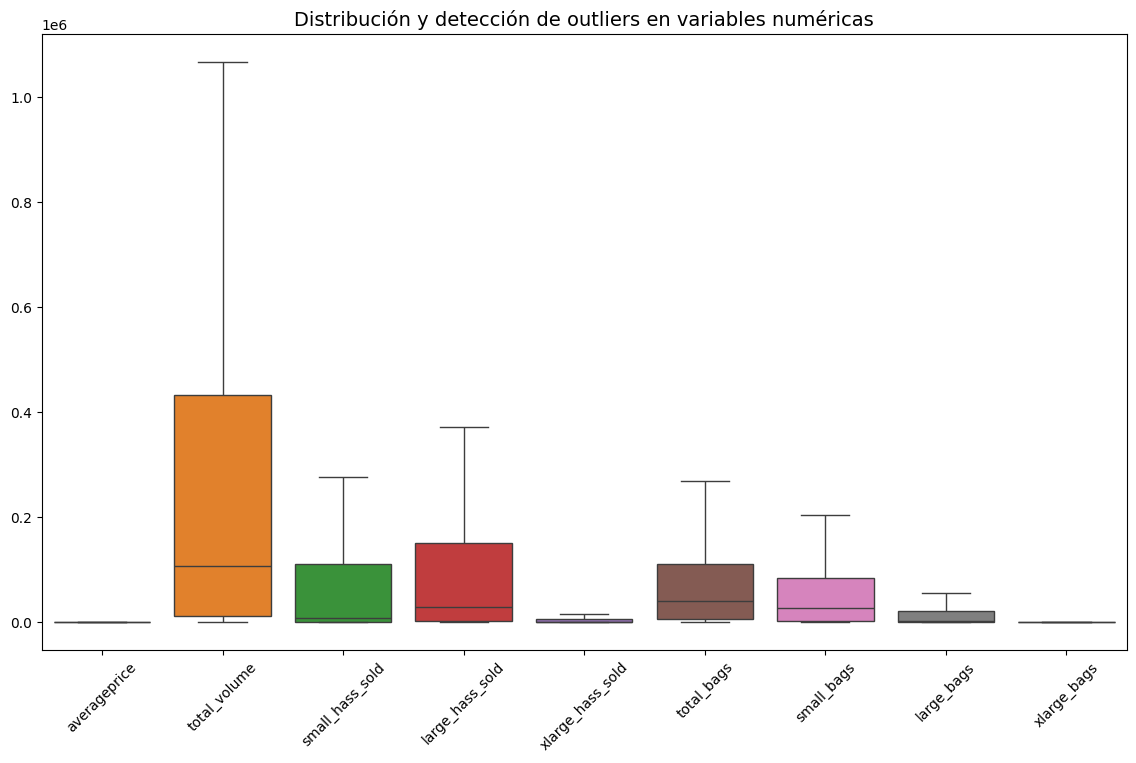

In [56]:
## Visualización de datos atípicos con boxplots

plt.figure(figsize=(14, 8))
sns.boxplot(data=df[numeric_cols])
plt.title("Distribución y detección de outliers en variables numéricas", fontsize=14)
plt.xticks(rotation=45)
plt.show()

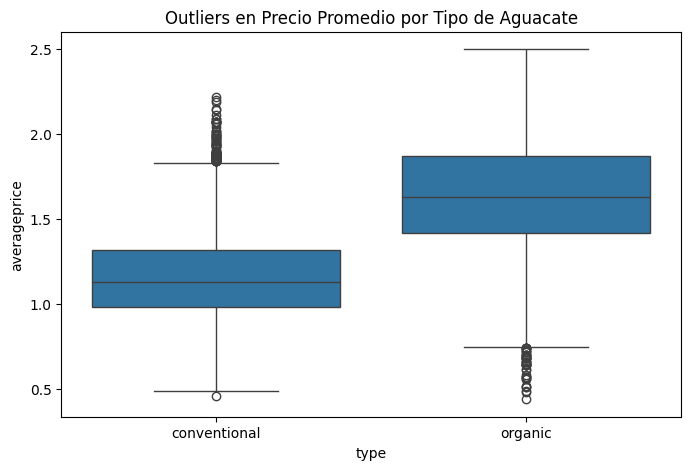

In [57]:
# Visualización de outliers en precio promedio por tipo de aguacate
plt.figure(figsize=(8, 5))
sns.boxplot(x='type', y='averageprice', data=df)
plt.title('Outliers en Precio Promedio por Tipo de Aguacate')
plt.show()

In [58]:
# Cálculo de límites con IQR, IQR es el rango intercuartílico
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR)))
outlier_counts = outliers.sum().sort_values(ascending=False)

print(outlier_counts)


averageprice        0
total_volume        0
small_hass_sold     0
large_hass_sold     0
xlarge_hass_sold    0
total_bags          0
small_bags          0
large_bags          0
xlarge_bags         0
dtype: int64


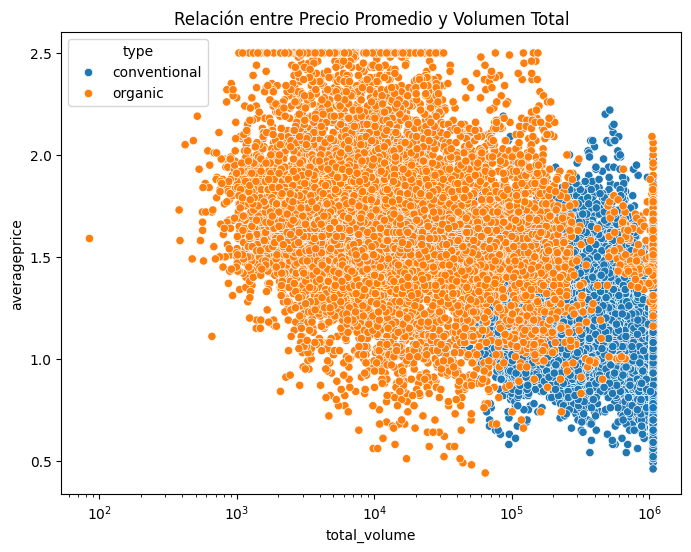

In [59]:
# Visualización de la relación entre precio promedio y volumen total
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_volume', y='averageprice', hue='type', data=df)
plt.title('Relación entre Precio Promedio y Volumen Total')
plt.xscale('log')  # escala logarítmica para visualizar mejor
plt.show()


In [74]:
# Cálculo de límites con IQR, IQR es el rango intercuartílico
Q1 = df['averageprice'].quantile(0.25)
Q3 = df['averageprice'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Separar datos normales y outliers
outliers = df[(df['averageprice'] < limite_inferior) | (df['averageprice'] > limite_superior)]
normales = df[(df['averageprice'] >= limite_inferior) & (df['averageprice'] <= limite_superior)]


In [ ]:
#miramos los tamaños de las muestras para verificar la cantidad de outliers

outliers.shape, normales.shape

((0, 15), (18249, 15))

C:\Users\jcgs9\AppData\Local\Temp\ipykernel_18904\3763612372.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Con Outliers', 'Sin Outliers'], y=[avg_with_outliers, avg_without_outliers], palette='pastel')


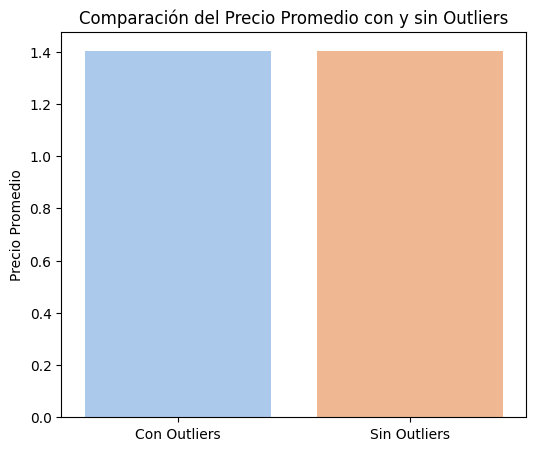

Precio promedio con outliers: 1.40
Precio promedio sin outliers: 1.40


In [ ]:
# Comparación de precios con y sin outliers
avg_with_outliers = df['averageprice'].mean()
avg_without_outliers = df[~df.index.isin(outliers.index)]['averageprice'].mean()

plt.figure(figsize=(6,5))
sns.barplot(x=['Con Outliers', 'Sin Outliers'], y=[avg_with_outliers, avg_without_outliers], palette='pastel')
plt.title('Comparación del Precio Promedio con y sin Outliers')
plt.ylabel('Precio Promedio')
plt.show()

print(f"Precio promedio con outliers: {avg_with_outliers:.2f}")
print(f"Precio promedio sin outliers: {avg_without_outliers:.2f}")


In [ ]:
# ==============================
# 3️⃣ Codificación de Variables Categóricas
# ==============================

df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [ ]:
df

,Date,averageprice,total_volume,small_hass_sold,large_hass_sold,xlarge_hass_sold,total_bags,small_bags,large_bags,xlarge_bags,year,region,days_since_start,month,type_organic
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,2015,Albany,357,12,False
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,2015,Albany,350,12,False
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,2015,Albany,343,12,False
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,2015,Albany,336,12,False
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,2015,Albany,329,11,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,2018,WestTexNewMexico,1127,2,True
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,2018,WestTexNewMexico,1120,1,True
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,2018,WestTexNewMexico,1113,1,True
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,2018,WestTexNewMexico,1106,1,True


In [ ]:
# ==============================
# 4️⃣ Escalado Estandarizado (Z-Score)
# ==============================

cols_to_scale = [
    'averageprice', 'total_volume', 'small_hass_sold', 'large_hass_sold',
    'xlarge_hass_sold', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags'
]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [ ]:
# ==============================
# 5️⃣ Verificación
# ==============================

print(df_scaled.info())
print(df_scaled.describe().T.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              18249 non-null  datetime64[ns]
 1   averageprice      18249 non-null  float64       
 2   total_volume      18249 non-null  float64       
 3   small_hass_sold   18249 non-null  float64       
 4   large_hass_sold   18249 non-null  float64       
 5   xlarge_hass_sold  18249 non-null  float64       
 6   total_bags        18249 non-null  float64       
 7   small_bags        18249 non-null  float64       
 8   large_bags        18249 non-null  float64       
 9   xlarge_bags       18249 non-null  float64       
 10  year              18249 non-null  int64         
 11  region            18249 non-null  object        
 12  days_since_start  18249 non-null  int64         
 13  month             18249 non-null  int32         
 14  type_organic      1824